In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. a ipython magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

from time import time
from subprocess import call
from epsilon.utils import jit_toy_data

# no need to worry about this part, it makes
# subsequent model evaluation runs faster
jit_toy_data()

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,epsilon

Ethen 2017-07-27 11:30:26 

CPython 3.5.2
IPython 5.4.1

numpy 1.13.1
pandas 0.20.2
matplotlib 2.0.2
epsilon 0.0.1


In [2]:
# download the data if it's not in the same local directory
file_dir = 'ml-100k'
file_path = os.path.join(file_dir, 'u.data')
if not os.path.isdir(file_dir):
    call(['curl', '-O', 'http://files.grouplens.org/datasets/movielens/' + file_dir + '.zip'])
    call(['unzip', file_dir + '.zip'])

In [3]:
from epsilon.utils import check_value_and_coltype


# pass the DataFrame and names of 
# the user, item and ratings columns
user_col = 'user_id'
item_col = 'item_id'
rating_col = 'rating'
timestamp_col = 'timestamp'

names = [user_col, item_col, rating_col, timestamp_col]
df = pd.read_csv(file_path, sep = '\t', names = names)

# this is simply a quick utility function to ensure
# the columns does not include nan values and convert
# type to string if they are not already
df = check_value_and_coltype(df, user_col, item_col)
print('data dimension: \n', df.shape)
df.head()

data dimension: 
 (100000, 4)


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
from datetime import datetime


def extract_time(row):
    timestamp = datetime.utcfromtimestamp(row)
    time = str(timestamp.year) + ',' + str(timestamp.month)
    return time
    

df[timestamp_col] = df[timestamp_col].apply(extract_time)
df_time = (df[timestamp_col]
           .str.split(',', expand = True)
           .rename(columns = {0: 'year', 1: 'month'}))

for col in df_time.columns:
    df_time[col] = df_time[col].apply(int)

df = df.drop(timestamp_col, axis = 1)
df = pd.concat([df, df_time], axis = 1)

# mask is the watershed for the train/test data
mask = (df['year'] == 1998) & (df['month'] >= 4)
df_train = df[~mask]
df_test = df[mask]

print('training set dimension: ', df_train.shape)
print('testing set dimension: ', df_test.shape)
df_train.head()

training set dimension:  (90641, 5)
testing set dimension:  (9359, 5)


,user_id,item_id,rating,year,month
0,196,242,3,1997,12
2,22,377,1,1997,11
3,244,51,2,1997,11
4,166,346,1,1998,2
5,298,474,4,1998,1


In [5]:
from epsilon.utils import RecommenderMatrix


dtype = 'float32'
rating_threshold = 4
rec_matrix = RecommenderMatrix(
    user_col, item_col, rating_col, rating_threshold = rating_threshold, dtype = dtype)

X_train = rec_matrix.fit_transform(df_train)
X_test = rec_matrix.transform(df_test)
X_train

<787x1133 sparse matrix of type '<class 'numpy.float32'>'
	with 18815 stored elements in Compressed Sparse Row format>

In [6]:
X_test

<787x1133 sparse matrix of type '<class 'numpy.float32'>'
	with 370 stored elements in Compressed Sparse Row format>

In [7]:
from epsilon.models import TensorflowBPR

bpr_params = {'n_factors': 10,
              'learning_rate': 0.1,
              'n_iters': 150,
              'reg': 0.01,
              'batch_size': 200}

bpr = TensorflowBPR(**bpr_params)
bpr.fit(X_train)

TensorflowBPR: 100%|██████████| 150/150 [00:03<00:00, 47.05it/s]


TensorflowBPR(batch_size=200, learning_rate=0.1, n_factors=10, n_iters=150,
       random_state=1234, reg=0.01, tensorboard='./graphs/bpr',
       verbose=True)

In [8]:
bpr_params = {'n_factors': 10,
              'learning_rate': 0.1,
              'n_iters': 150,
              'reg': 0.01,
              'batch_size': 200,
              'tensorboard': '.graphs/bpr1'}

bpr1 = TensorflowBPR(**bpr_params)
bpr1.fit(X_train)

TensorflowBPR: 100%|██████████| 150/150 [00:03<00:00, 49.01it/s]


TensorflowBPR(batch_size=200, learning_rate=0.1, n_factors=10, n_iters=150,
       random_state=1234, reg=0.01, tensorboard='.graphs/bpr1',
       verbose=True)

In [10]:
from epsilon.metrics import auc_score, ndcg_score, map_score


bpr_auc_train = auc_score(bpr, X_train)
bpr_auc_test = auc_score(bpr, X_test)
print('auc training:', bpr_auc_train)
print('auc testing:', bpr_auc_test)

auc training: 0.9153902865988581
auc testing: 0.8285711955454558


In [11]:
k = 5
bpr_ndcg_train = ndcg_score(bpr, X_train, k)
bpr_ndcg_test = ndcg_score(bpr, X_test, k)
print('ndcg training:', bpr_ndcg_train)
print('ndcg testing:', bpr_ndcg_test)

ndcg training: 0.43910670767553744
ndcg testing: 0.07873294193662587


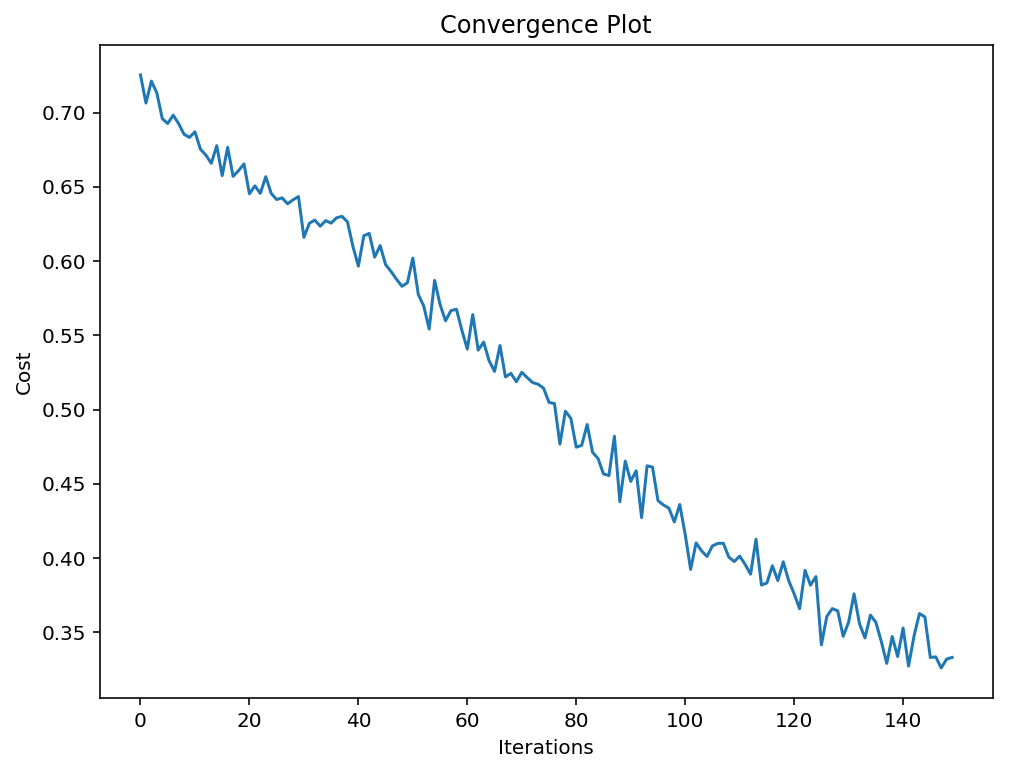

In [12]:
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 10

plt.plot(bpr.history_)
plt.title('Convergence Plot')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

In [ ]:
!tensorboard --logdir='./graphs/bpr/' --port=8000

In [ ]:
similar_items = bpr.get_similar_items(N = 5)
similar_items

In [ ]:
recommendation = bpr.recommend(X_train, N = 5)
recommendation